In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
# Following tutorial: https://medium.com/@prathik.codes/mastering-randomforestregressor-in-scikit-learn-a-practical-guide-ba8615097100
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({"figure.dpi": 300})
sns.set_context('paper')
sns.set_style('whitegrid')

In [2]:
test_results = pd.read_csv('../data/stat_test_results.csv')

In [3]:
# Find locations where Kruskall-Wallis test was significant
# These should be the most important locations to look at when deciding flowering time
cols = test_results.loc[test_results['corrected_pval'] < 0.01,'location'].to_list()

In [4]:
data = pd.read_csv('../data/processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})

In [5]:
# Filter dataset to only include significant SNPs and flowering time
data = data[['5_FT10']+cols]
data

,5_FT10,1:3877554,5:3188327,2:9581605,2:9604507,1:3849924,2:13618247,1:3840597,1:3844044,1:3872387,...,4:16102433,2:13146146,1:3860220,1:24329671,5:26945835,5:18601034,1:19618944,5:3054187,1:30175419,3:20197802
1,100.0,G,T,C,C,A,A,C,T,G,...,C,G,T,A,A,T,C,G,G,A
2,96.3,G,C,C,C,A,A,C,T,G,...,C,G,T,A,A,T,C,A,G,A
3,100.0,G,T,C,C,A,A,C,T,G,...,C,G,T,A,G,C,T,G,G,A
4,60.5,A,C,G,A,T,G,T,G,A,...,T,A,A,A,A,T,T,A,C,C
5,98.0,A,T,G,A,T,A,T,G,A,...,C,A,A,T,G,C,C,A,G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,100.0,G,T,G,A,A,A,C,T,G,...,T,A,T,A,G,C,T,A,G,A
227,90.7,G,T,G,A,A,G,C,T,G,...,T,A,T,A,A,C,C,G,G,A
228,86.0,G,C,G,A,A,A,C,T,G,...,C,G,T,A,G,C,T,A,G,A
229,105.0,G,T,C,C,A,A,C,T,G,...,C,G,T,A,G,C,T,G,G,A


In [6]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]
enc = preprocessing.OneHotEncoder(drop='if_binary')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

y_train = train['5_FT10']
y_test = test['5_FT10']

In [7]:
# Random forest with default parameters
base_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
)

base_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = base_rf.predict(X_test)
print(mean_squared_error(y_test, y_pred))

116.4260603913045


In [9]:
r2_score(y_test, y_pred)

0.755801115741116

In [10]:
# Optimizing the model using gridsearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
param_grid = {
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': [10, 100, 1000],
    'max_depth': [10, 100, 1000, None],
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2)

In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time=   0.3s
[CV] END .max_depth=10, max_features=sqrt, n_es

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10, 100, ...], 'max_features': ['sqrt', 'log2', ...], 'n_estimators': [10, 100, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [12]:
grid_search.best_params_

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 1000}

In [13]:
best_rf = grid_search.best_estimator_

In [14]:
best_y_pred = best_rf.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, best_y_pred)}')
print(f'R^2: {r2_score(y_test, best_y_pred)}')

MSE: 116.19705075826009
R^2: 0.756281454049275


In [15]:
# Building model with full feature set
data_full = pd.read_csv('../data/processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})
full_train, full_test = train_test_split(data_full, test_size=0.1, random_state=42)
full_X_train = full_train[full_train.columns[2:]]
full_X_test = full_test[full_test.columns[2:]]

In [16]:
categories = [['A', 'C', 'T', 'G'] for i in range(len(full_X_train.columns))]
enc_full = preprocessing.OneHotEncoder(categories=categories)
full_X_train = enc_full.fit_transform(full_X_train)
full_X_test = enc_full.transform(full_X_test)
full_y_train = full_train['5_FT10']
full_y_test = full_test['5_FT10']

In [17]:
base_rf_full = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
)

base_rf_full.fit(full_X_train, full_y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred_full = base_rf_full.predict(full_X_test)
print(f'MSE: {mean_squared_error(full_y_test, y_pred_full)}')
print(f'R^2: {r2_score(full_y_test, y_pred_full)}')
# base model using full feature set has pretty bad performance 
# and training time was long (about 4 minutes) so I don't think 
# it's worth it to optimize it.

MSE: 192.85431195652177
R^2: 0.595495994230045


In [19]:
# Get highest relative importances of each feature in the reduced model and plot them
importances = pd.Series(best_rf.feature_importances_, train.columns[1:]).sort_values(ascending=False)
top_20 = importances[:20]

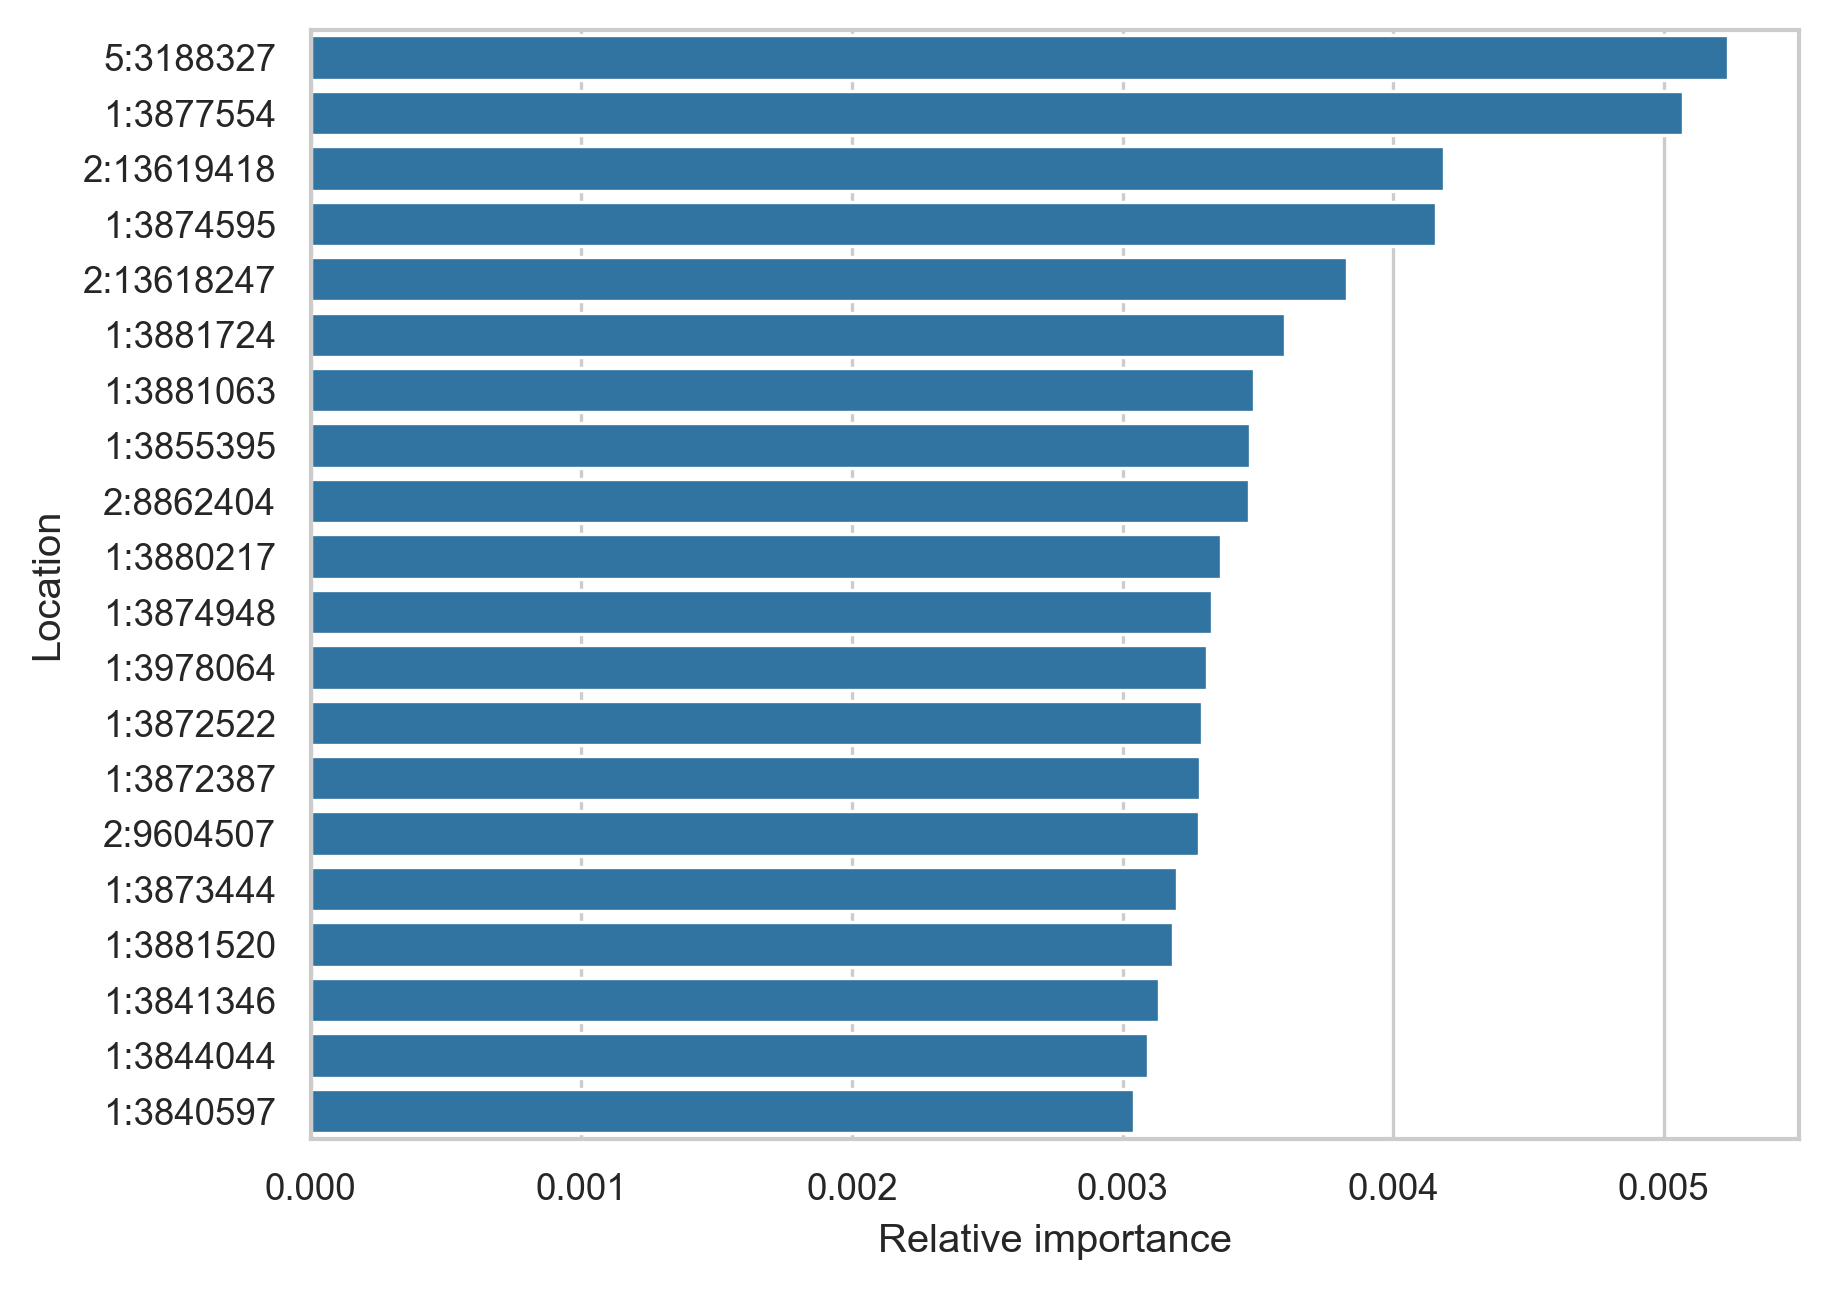

In [25]:
importance_plot = sns.barplot(x=top_20.values, y=top_20.index)
importance_plot.set_ylabel('Location')
importance_plot.set_xlabel('Relative importance')
plt.show()

In [21]:
importance_df = pd.DataFrame({'location': top_20.index, 'importance': top_20.values})
importance_df['chromosome'] = importance_df['location'].map(lambda x: str.split(x,':')[0])
importance_df['position'] = importance_df['location'].map(lambda x: str.split(x,':')[1]).astype(int)
importance_df

,location,importance,chromosome,position
0,5:3188327,0.005237,5,3188327
1,1:3877554,0.005071,1,3877554
2,2:13619418,0.004187,2,13619418
3,1:3874595,0.004157,1,3874595
4,2:13618247,0.003831,2,13618247
5,1:3881724,0.003599,1,3881724
6,1:3881063,0.003485,1,3881063
7,1:3855395,0.003472,1,3855395
8,2:8862404,0.003467,2,8862404
9,1:3880217,0.003362,1,3880217


In [22]:
# Compare these results to gene model
# Columns named according to: https://useast.ensembl.org/info/website/upload/gff.html
gff_names = ['Chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
gene_model = pd.read_table('../data/gene_model.gff', sep='\t', header=None, names=gff_names)
gene_model['Chr'] = gene_model['Chr'].map(lambda x: str.replace(x, 'Chr', ''))
gene_model

,Chr,source,feature,start,end,score,strand,frame,attribute
0,1,TAIR10,chromosome,1,30427671,.,.,.,ID=Chr1;Name=Chr1
1,1,TAIR10,gene,3631,5899,.,+,.,ID=AT1G01010;Note=protein_coding_gene;Name=AT1...
2,1,TAIR10,mRNA,3631,5899,.,+,.,ID=AT1G01010.1;Parent=AT1G01010;Name=AT1G01010...
3,1,TAIR10,protein,3760,5630,.,+,.,ID=AT1G01010.1-Protein;Name=AT1G01010.1;Derive...
4,1,TAIR10,exon,3631,3913,.,+,.,Parent=AT1G01010.1
...,...,...,...,...,...,...,...,...,...
590259,M,TAIR10,gene,366086,366700,.,-,.,ID=ATMG01410;Note=protein_coding_gene;Name=ATM...
590260,M,TAIR10,mRNA,366086,366700,.,-,.,ID=ATMG01410.1;Parent=ATMG01410;Name=ATMG01410...
590261,M,TAIR10,protein,366086,366700,.,-,.,ID=ATMG01410.1-Protein;Name=ATMG01410.1;Derive...
590262,M,TAIR10,CDS,366086,366700,.,-,0,"Parent=ATMG01410.1,ATMG01410.1-Protein;"


In [23]:
# Find genes that the most important SNPs are in
match_df = pd.DataFrame(columns=gene_model.columns.to_list() + ['SNP location'])
for i in importance_df.index:
    row = importance_df.loc[i,:]
    chrom = row['chromosome']
    position = row['position']
    matches = gene_model.loc[(gene_model['Chr'] == chrom) & (gene_model['start'] < position) & (gene_model['end'] > position) & (gene_model['feature'] != 'chromosome'),:].copy()
    if len(matches) > 0:
        matches.loc[:,'SNP location'] = [position] * len(matches)
        match_df = pd.concat([match_df, matches], axis='index')

match_df.reset_index(inplace=True, drop=True)


In [24]:
# Extract gene name from attribute column and before saving
match_df['gene name'] = match_df['attribute'].map(lambda x: str.split(x, ';')[0].split('=')[1])
match_df = match_df.sort_values(by=['Chr', 'start'])
match_df=match_df.loc[match_df['feature']=='gene']
match_df.loc[:,['Chr', 'start', 'end','SNP location', 'gene name']].to_csv('../data/gene_annotations.csv', index=False)